In [7]:
import random
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

from torch.optim import SGD, Adam
from torch.nn import MSELoss
import matplotlib.pyplot as plt


In [2]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [3]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout=0):
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        
        # Add embedding layers
        self.user_embedding_mf = nn.Embedding(nb_users + 1, mf_dim)
        self.item_embedding_mf = nn.Embedding(nb_items + 1, mf_dim)
        self.user_embedding_mlp = nn.Embedding(nb_users + 1, mlp_layer_sizes[0] // 2)
        self.item_embedding_mlp = nn.Embedding(nb_items + 1, mlp_layer_sizes[0] // 2)

        # Add MLPs and the final layer
        layers = []
        input_size = mlp_layer_sizes[0]
        for output_size in mlp_layer_sizes[1:]:
            layers.append(nn.Linear(input_size, output_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=dropout))
            input_size = output_size
        self.mlp_layers = nn.Sequential(*layers)
        
        self.final = nn.Linear(mf_dim + mlp_layer_sizes[-1], 1)
        
        # Initialize weights
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        
        for layer in self.mlp_layers:
            if isinstance(layer, nn.Linear):
                glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        # Get MF and MLP embeddings
        user_embedding_mf = self.user_embedding_mf(user)
        item_embedding_mf = self.item_embedding_mf(item)
        user_embedding_mlp = self.user_embedding_mlp(user)
        item_embedding_mlp = self.item_embedding_mlp(item)
        
        # MF vector
        mf_vector = user_embedding_mf * item_embedding_mf
        
        # MLP vector
        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)
        mlp_vector = self.mlp_layers(mlp_vector)
        
        # Concatenate MF and MLP vectors
        vector = torch.cat([mf_vector, mlp_vector], dim=-1)
        
        # Final output
        output = self.final(vector)
        if sigmoid:
            output = torch.sigmoid(output)
        return output

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [4]:
class ML100kDataset(Dataset):
    def __init__(self, file_name, nb_users, nb_items, negative_samples=1):
        ratings_df = pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], delim_whitespace=True)
        
        # Verify ranges
        if ratings_df['user_id'].max() > nb_users or ratings_df['item_id'].max() > nb_items:
            raise ValueError(f"User or item indices exceed the specified number of users/items: max user_id={ratings_df['user_id'].max()}, max item_id={ratings_df['item_id'].max()}")

        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating', 'timestamp'], axis=1, inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)

        # Positive samples
        self.users = ratings[:, 0]
        self.items = ratings[:, 1]
        self.labels = torch.ones(self.raw_dataset_length)

        # Negative samples
        negative_users = self.users.repeat(negative_samples)
        negative_items = torch.randint(1, max_item + 1, (self.raw_dataset_length * negative_samples,))
        negative_labels = torch.zeros(self.raw_dataset_length * negative_samples)

        # Concatenate positive and negative samples
        self.users = torch.cat((self.users, negative_users))
        self.items = torch.cat((self.items, negative_items))
        self.labels = torch.cat((self.labels, negative_labels))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]




### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [5]:
#YOUR TASK: Implement entire training loop for the model with selection of HPs ~25+ lines of code
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, shuffle=True):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for users, items, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            predictions = model(users, items, sigmoid=True).squeeze()
            loss = criterion(predictions, labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for users, items, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                predictions = model(users, items, sigmoid=True).squeeze()
                loss = criterion(predictions, labels.float())
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

def plot_learning_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
# Hyperparameters
nb_users, nb_items = 943, 1682  # Number of users and items in ML-100k dataset
mf_dim = 10
mlp_layer_sizes = [64, 32, 16, 8]
dropout = 0.5
batch_size = 32
num_epochs = 10
learning_rate = 0.001
negative_samples = 4

# Initialize dataset
dataset = ML100kDataset('ml-100k/u.data', nb_users=nb_users, nb_items=nb_items, negative_samples=negative_samples)

# Split dataset into training and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize model
model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train the model
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)



Validation Epoch 1/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 816.47it/s]


Epoch 1/10, Train Loss: 0.4830, Val Loss: 0.4271


Validation Epoch 2/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 834.82it/s]


Epoch 2/10, Train Loss: 0.4275, Val Loss: 0.4088


Validation Epoch 3/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 854.91it/s]


Epoch 3/10, Train Loss: 0.4172, Val Loss: 0.4049


Validation Epoch 4/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 967.14it/s]


Epoch 4/10, Train Loss: 0.4121, Val Loss: 0.4044


Validation Epoch 5/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 954.37it/s]


Epoch 5/10, Train Loss: 0.4100, Val Loss: 0.4060


Validation Epoch 6/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:04<00:00, 720.57it/s]


Epoch 6/10, Train Loss: 0.4056, Val Loss: 0.4075


Validation Epoch 7/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 829.58it/s]


Epoch 7/10, Train Loss: 0.4002, Val Loss: 0.4079


Validation Epoch 8/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 977.03it/s]


Epoch 8/10, Train Loss: 0.3919, Val Loss: 0.4066


Validation Epoch 9/10: 100%|███████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 793.63it/s]


Epoch 9/10, Train Loss: 0.3823, Val Loss: 0.4020


Validation Epoch 10/10: 100%|██████████████████████████████████████████████████████| 3125/3125 [00:03<00:00, 882.78it/s]

Epoch 10/10, Train Loss: 0.3726, Val Loss: 0.3988


### Plot results

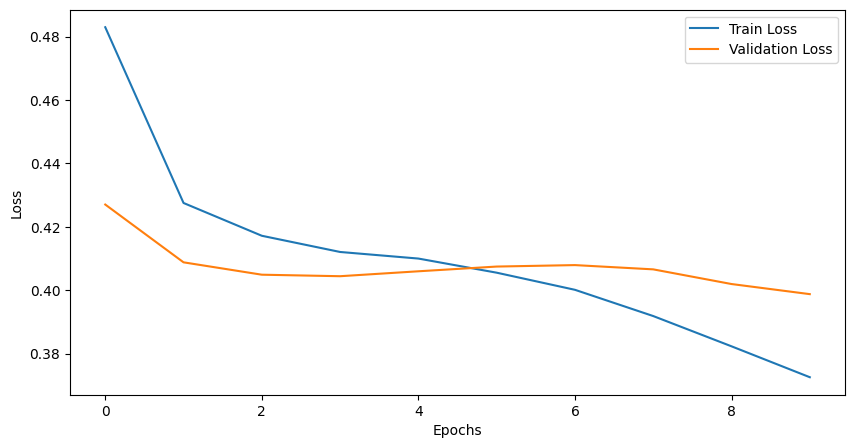

In [9]:
# Plot learning curves
plot_learning_curves(train_losses, val_losses)


### HPs optimization

In [17]:
def compute_hr_at_n(model, test_loader, top_n=10):
    hits = 0
    total = 0
    with torch.no_grad():
        for users, items, labels in test_loader:
            predictions = model(users, items, sigmoid=True)
            _, indices = torch.topk(predictions, top_n, dim=1)
            for user, item, label, top_items in zip(users, items, labels, indices):
                if label == 1 and item in top_items:
                    hits += 1
                total += 1
    return hits / total


In [18]:
def train_model_with_hr(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs=5, shuffle=True, top_n=10):
    train_losses = []
    val_losses = []
    hr_values = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for users, items, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            predictions = model(users, items, sigmoid=True).squeeze()
            loss = criterion(predictions, labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for users, items, labels in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                predictions = model(users, items, sigmoid=True).squeeze()
                loss = criterion(predictions, labels.float())
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        hr_at_n = compute_hr_at_n(model, test_loader, top_n=top_n)
        hr_values.append(hr_at_n)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, HR@{top_n}: {hr_at_n:.4f}")

    return train_losses, val_losses, hr_values


In [19]:
import torch.optim as optim


In [23]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5, shuffle=True):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for batch_idx, batch_data in enumerate(train_loader):
            optimizer.zero_grad()
            users, items, targets = batch_data
            predictions = model(users, items, sigmoid=True).squeeze()
            loss = criterion(predictions, targets.float())
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        
        epoch_train_loss /= len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for batch_data in val_loader:
                users, items, targets = batch_data
                predictions = model(users, items, sigmoid=True).squeeze()
                loss = criterion(predictions, targets.float())
                epoch_val_loss += loss.item()
        
        epoch_val_loss /= len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Val Loss: {epoch_val_loss:.6f}")

    return train_losses, val_losses


Epoch 1/10, Train Loss: 0.479977, Val Loss: 0.417761
Epoch 2/10, Train Loss: 0.422857, Val Loss: 0.408854
Epoch 3/10, Train Loss: 0.413656, Val Loss: 0.402174
Epoch 4/10, Train Loss: 0.411165, Val Loss: 0.401090
Epoch 5/10, Train Loss: 0.409778, Val Loss: 0.402378
Epoch 6/10, Train Loss: 0.407228, Val Loss: 0.402139
Epoch 7/10, Train Loss: 0.403627, Val Loss: 0.403585
Epoch 8/10, Train Loss: 0.397565, Val Loss: 0.403571
Epoch 9/10, Train Loss: 0.390369, Val Loss: 0.402388
Epoch 10/10, Train Loss: 0.380191, Val Loss: 0.399867
Epoch 1/10, Train Loss: 0.486641, Val Loss: 0.418912
Epoch 2/10, Train Loss: 0.424148, Val Loss: 0.405655
Epoch 3/10, Train Loss: 0.415501, Val Loss: 0.402006
Epoch 4/10, Train Loss: 0.413481, Val Loss: 0.399891
Epoch 5/10, Train Loss: 0.410490, Val Loss: 0.401764
Epoch 6/10, Train Loss: 0.407534, Val Loss: 0.403038
Epoch 7/10, Train Loss: 0.404549, Val Loss: 0.402842
Epoch 8/10, Train Loss: 0.397619, Val Loss: 0.403362
Epoch 9/10, Train Loss: 0.390655, Val Loss: 0

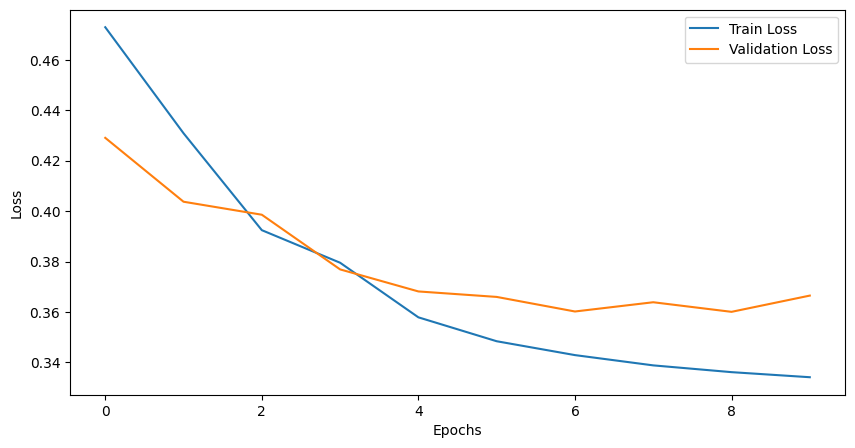

NameError: name 'test_loader' is not defined

In [24]:
import itertools

# Define hyperparameters to search
learning_rates = [0.001, 0.01, 0.1]
momentums = [0.9, 0.95]
batch_sizes = [32, 64]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(itertools.product(learning_rates, momentums, batch_sizes))

# Perform cross-validation to find the best hyperparameters
best_hyperparameters = None
best_val_loss = float('inf')

for lr, momentum, batch_size in hyperparameter_combinations:
    # Initialize model
    model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout)
    
    # Define loss and optimizer
    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr=lr)
    
    # Train the model
    train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)
    
    # Check if this combination has the best validation loss
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        best_hyperparameters = (lr, momentum, batch_size)

print("Best Hyperparameters:", best_hyperparameters)

# Now train the model with the best hyperparameters
lr, momentum, batch_size = best_hyperparameters
model = NeuMF(nb_users, nb_items, mf_dim, mlp_layer_sizes, dropout)
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=lr)
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=num_epochs)

# Plot learning curves
plot_learning_curves(train_losses, val_losses)

# Plot HR@n values
hr_values = compute_hr_at_n(model, test_loader, top_n=10)  # Assuming you have this function
plot_hr_at_n(hr_values, top_n=10)
